In [1]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

from scipy.sparse import csr_matrix

from lassonet import LassoNetRegressor

In [2]:
bivae_full = pd.read_feather('../data/full_pred_bivae_100k.feather').drop('index', 1)
bpr_full = pd.read_feather('../data/full_pred_bpr_100k.feather').drop('index', 1)

In [3]:
# Re-index; 

all_items_bivae = pd.unique(bivae_full['itemID'])
all_items_bivae.sort()
all_users_bivae = pd.unique(bivae_full['userID'])
all_users_bivae.sort()

index_to_item = dict(enumerate(all_items_bivae))
index_to_user = dict(enumerate(all_users_bivae))

item_to_index = {v: k for k, v in index_to_item.items()}
user_to_index = {v: k for k, v in index_to_user.items()}

bivae_full = bivae_full.replace({'itemID': item_to_index})
bivae_full = bivae_full.replace({'userID': user_to_index})

In [4]:
all_items_bpr = pd.unique(bpr_full['itemID'])
all_items_bpr.sort()
all_users_bpr = pd.unique(bpr_full['userID'])
all_users_bpr.sort()

index_to_item = dict(enumerate(all_items_bpr))
index_to_user = dict(enumerate(all_users_bpr))

item_to_index = {v: k for k, v in index_to_item.items()}
user_to_index = {v: k for k, v in index_to_user.items()}

bpr_full = bpr_full.replace({'itemID': item_to_index})
bpr_full = bpr_full.replace({'userID': user_to_index})

In [5]:
X_bivae = csr_matrix((bivae_full.prediction.values, (bivae_full.userID.values, bivae_full.itemID.values)),).toarray()
X_bpr = csr_matrix((bpr_full.prediction.values, (bpr_full.userID.values, bpr_full.itemID.values)),).toarray()


In [6]:
X_bivae = StandardScaler().fit_transform(X_bivae)
X_bpr = StandardScaler().fit_transform(X_bpr)

In [7]:
X_bivae_train, X_bivae_test = train_test_split(X_bivae)
X_bpr_train, X_bpr_test = train_test_split(X_bpr)

In [8]:
reg_bivae = LassoNetRegressor(hidden_dims=[500])
path_bivae = reg_bivae.path(X_bivae_train, X_bivae_train)

reg_bpr = LassoNetRegressor(hidden_dims=[500])
path_bpr = reg_bpr.path(X_bpr_train, X_bpr_train)

### Plot regularization path and feature importance for BiVAE matrix

In [9]:
plt.rcParams.update({'font.size': 22})

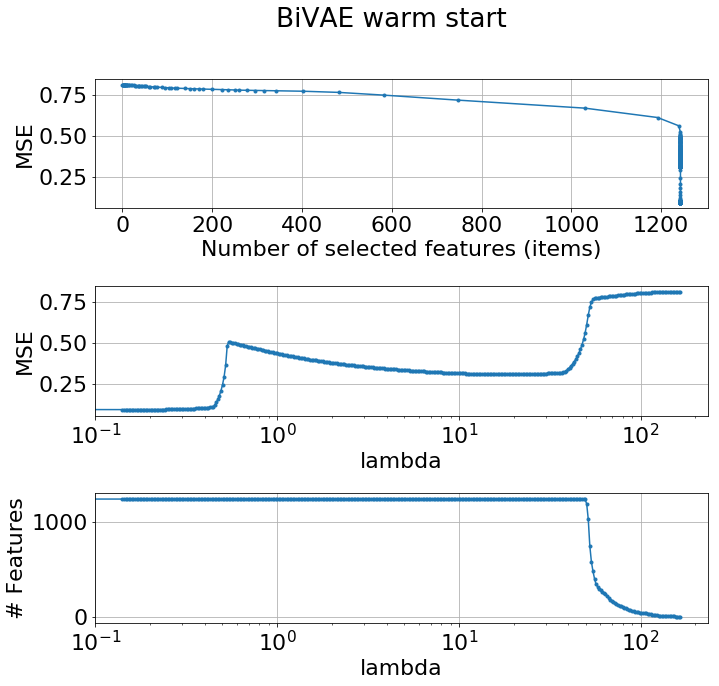

In [10]:
n_selected = []
mse = []
lambda_ = []

for save in path_bivae:
    reg_bivae.load(save.state_dict)
    X_pred = reg_bivae.predict(X_bivae_test)
    n_selected.append(save.selected.sum())
    mse.append(mean_squared_error(X_bivae_test, X_pred))
    lambda_.append(save.lambda_)

fig = plt.figure(figsize=(11, 10))

plt.suptitle("BiVAE warm start")

plt.subplot(311)
plt.grid(True)
plt.plot(n_selected, mse, ".-")
plt.xlabel("Number of selected features (items)")
plt.ylabel("MSE")

plt.subplot(312)
plt.grid(True)
plt.plot(lambda_, mse, ".-")
plt.xlabel("lambda")
plt.xscale("log")
plt.ylabel("MSE")

plt.subplot(313)
plt.grid(True)
plt.plot(lambda_, n_selected, ".-")
plt.xlabel("lambda")
plt.xscale("log")
plt.ylabel("# Features")

fig.subplots_adjust(hspace=0.6)
plt.savefig("../tex/figs/bivae_regpath.png")

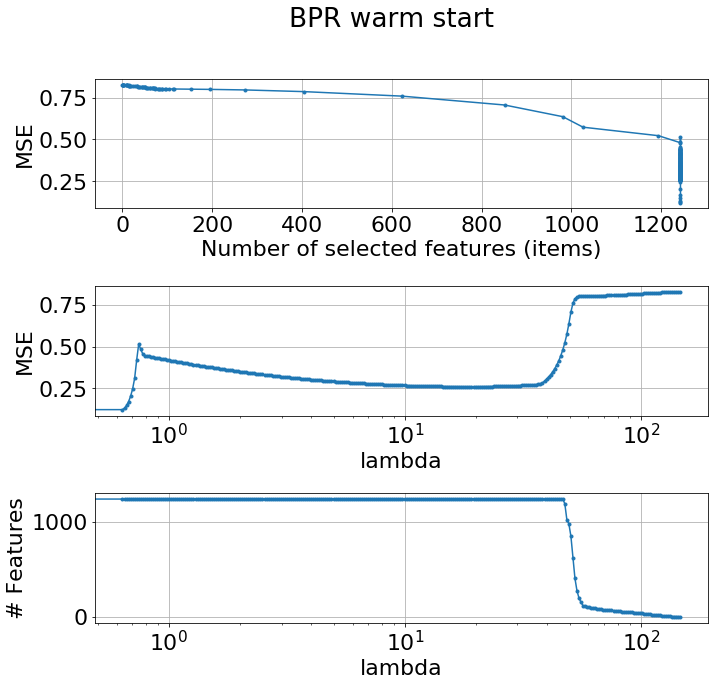

In [11]:
n_selected = []
mse = []
lambda_ = []

for save in path_bpr:
    reg_bpr.load(save.state_dict)
    X_pred = reg_bpr.predict(X_bpr_test)
    n_selected.append(save.selected.sum())
    mse.append(mean_squared_error(X_bpr_test, X_pred))
    lambda_.append(save.lambda_)

fig = plt.figure(figsize=(11, 10))

plt.suptitle("BPR warm start")

plt.subplot(311)
plt.grid(True)
plt.plot(n_selected, mse, ".-")
plt.xlabel("Number of selected features (items)")
plt.ylabel("MSE")

plt.subplot(312)
plt.grid(True)
plt.plot(lambda_, mse, ".-")
plt.xlabel("lambda")
plt.xscale("log")
plt.ylabel("MSE")

plt.subplot(313)
plt.grid(True)
plt.plot(lambda_, n_selected, ".-")
plt.xlabel("lambda")
plt.xscale("log")
plt.ylabel("# Features")

fig.subplots_adjust(hspace=0.6)
plt.savefig("../tex/figs/bpr_regpath.png")

This is personally what I've been waiting for -- what are the top movies from each regularization path?

In [12]:
imp_bivae = reg_bivae.feature_importances_.numpy()
top_indices = np.argsort(imp_bivae)
top_ids_bivae = [index_to_item[index] for index in top_indices]

In [13]:
print('top:', top_ids_bivae[0:5])
print('bottom:', top_ids_bivae[-5:])

top: [1459, 1075, 58, 1100, 739]
bottom: [1170, 241, 642, 267, 695]


In [14]:
imp_bpr2 = reg_bpr.feature_importances_.numpy()
top_indices = np.argsort(imp_bpr2)
top_ids_bpr = [index_to_item[index] for index in top_indices]


In [15]:
print('top:', top_ids_bpr[0:5])
print('bottom:', top_ids_bpr[-5:])

top: [84, 1100, 1230, 537, 587]
bottom: [168, 22, 258, 56, 172]


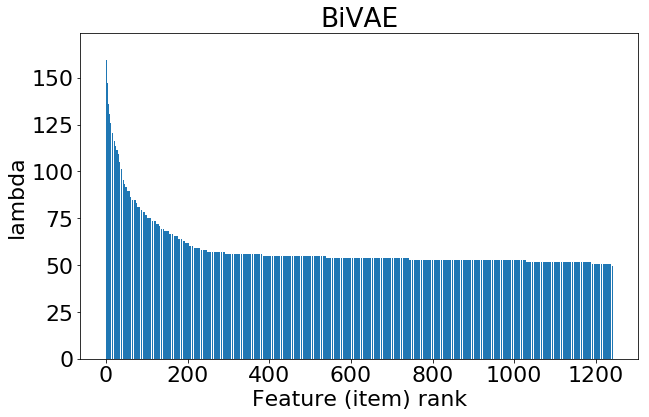

In [16]:
# Importance -- the value of lambda at which this feature disappears

imp_bivae = reg_bivae.feature_importances_.numpy()
imp_bivae.sort()
imp_bivae = imp_bivae[::-1]
imp_index = np.arange(imp_bivae.shape[0])

fig = plt.figure(figsize=(10, 6))
plt.title('BiVAE')
plt.bar(imp_index, imp_bivae)
plt.xlabel("Feature (item) rank")
plt.ylabel("lambda")

plt.savefig('../tex/figs/bivae_importance.png')

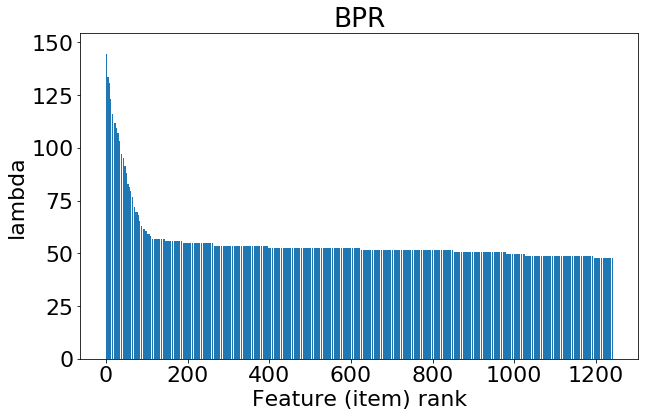

In [17]:
imp_bpr = reg_bpr.feature_importances_.numpy()
imp_bpr.sort()
imp_bpr = imp_bpr[::-1]
imp_index = np.arange(imp_bpr.shape[0])

fig = plt.figure(figsize=(10, 6))
plt.title('BPR')
plt.bar(imp_index, imp_bpr)
plt.xlabel("Feature (item) rank")
plt.ylabel("lambda")

plt.savefig('../tex/figs/bpr_importance.png')